In [ ]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, resize

In [ ]:
# Step 1: Create the phantom (ground truth image x)
image = shepp_logan_phantom()
image = resize(image, (256, 256))

In [ ]:
# Step 2: Generate sinogram (b = A x)
theta = np.linspace(0., 180., 180, endpoint=False)
sinogram = radon(image, theta=theta, circle=True)

In [ ]:
sinogram.shape

(256, 180)

In [ ]:
# Step 3: Reconstruct the image (x̂ ≈ A⁻¹ b)
reconstruction = iradon(sinogram, theta=theta, circle=True)

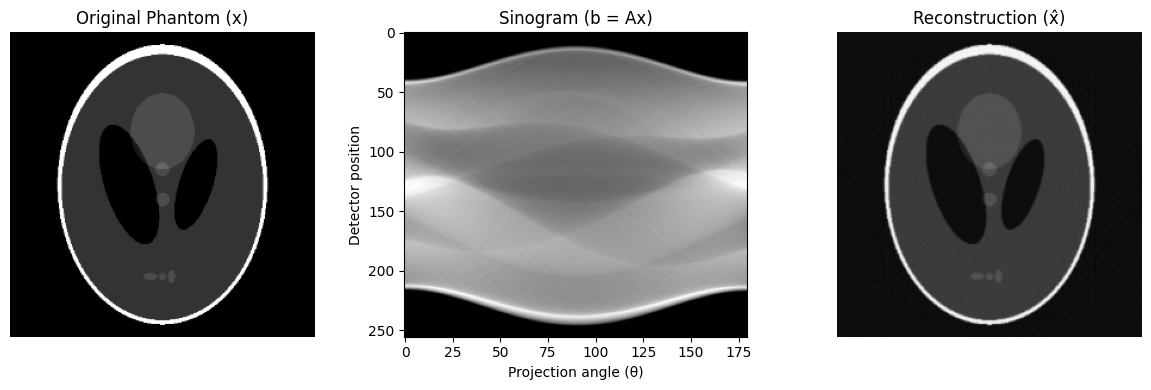

In [ ]:
# Step 4: Display
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Phantom (x)")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Sinogram (b = Ax)")
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.xlabel('Projection angle (θ)')
plt.ylabel('Detector position')

plt.subplot(1, 3, 3)
plt.title("Reconstruction (x̂)")
plt.imshow(reconstruction, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

#but all this was done using parallel beam geometry
#we need to figure out how to do fan beam geometry

In [ ]:
pip install astra-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 118.7 MB/s eta 0:00:00


In [ ]:
#we will use astra toolbox to do the fan beam geometry
import astra

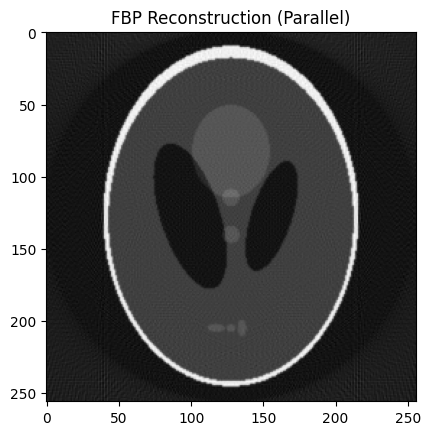

In [ ]:
# create geometries and projector
#this is for parallel projection and direct back projection algorithm (FBP)
proj_geom = astra.create_proj_geom('parallel', 1.0, 256, np.linspace(0, np.pi, 180, endpoint=False))
vol_geom = astra.create_vol_geom(256,256)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

# generate phantom image
V_exact_id, V_exact = astra.data2d.shepp_logan(vol_geom)

# create forward projection
sinogram_id_parallel, sinogram_parallel = astra.create_sino(V_exact, proj_id)

# reconstruct
# initialize with ones to allow for multiplicative updates
recon_id = astra.data2d.create('-vol', vol_geom, 1.0)
cfg = astra.astra_dict('FBP_CUDA')
cfg['ProjectorId'] = proj_id
cfg['ProjectionDataId'] = sinogram_id_parallel
cfg['ReconstructionDataId'] = recon_id
em_id = astra.algorithm.create(cfg)
astra.algorithm.run(em_id, 200)
V_fbp_para = astra.data2d.get(recon_id)
plt.gray()
plt.imshow(V_fbp_para)
plt.title("FBP Reconstruction (Parallel)")
plt.show()

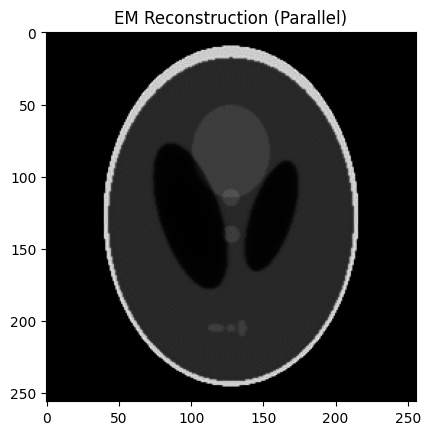

In [ ]:
# create geometries and projector
#this is for parallel projection and iterative back projection algorithm (EM)
proj_geom = astra.create_proj_geom('parallel', 1.0, 256, np.linspace(0, np.pi, 180, endpoint=False))
vol_geom = astra.create_vol_geom(256,256)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

# generate phantom image
V_exact_id, V_exact = astra.data2d.shepp_logan(vol_geom)

# create forward projection
sinogram_id_parallel, sinogram_parallel = astra.create_sino(V_exact, proj_id)

# reconstruct
# initialize with ones to allow for multiplicative updates
recon_id = astra.data2d.create('-vol', vol_geom, 1.0)
cfg = astra.astra_dict('EM_CUDA')
cfg['ProjectorId'] = proj_id
cfg['ProjectionDataId'] = sinogram_id_parallel
cfg['ReconstructionDataId'] = recon_id
em_id = astra.algorithm.create(cfg)
astra.algorithm.run(em_id, 200)
V_em_para = astra.data2d.get(recon_id)
plt.gray()
plt.imshow(V_em_para)
plt.title("EM Reconstruction (Parallel)")
plt.show()

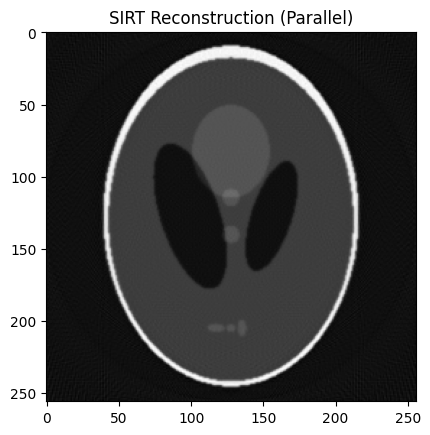

In [ ]:
# create geometries and projector
#this is for parallel projection and iterative back projection algorithm (SIRT)
proj_geom = astra.create_proj_geom('parallel', 1.0, 256, np.linspace(0, np.pi, 180, endpoint=False))
vol_geom = astra.create_vol_geom(256,256)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

# generate phantom image
V_exact_id, V_exact = astra.data2d.shepp_logan(vol_geom)

# create forward projection
sinogram_id_parallel, sinogram_parallel = astra.create_sino(V_exact, proj_id)

# reconstruct
# initialize with ones to allow for multiplicative updates
recon_id = astra.data2d.create('-vol', vol_geom, 1.0)
cfg = astra.astra_dict('SIRT_CUDA')
cfg['ProjectorId'] = proj_id
cfg['ProjectionDataId'] = sinogram_id_parallel
cfg['ReconstructionDataId'] = recon_id
sirt_id = astra.algorithm.create(cfg)
astra.algorithm.run(sirt_id, 200)
V_sirt_para = astra.data2d.get(recon_id)
plt.gray()
plt.imshow(V_sirt_para)
plt.title("SIRT Reconstruction (Parallel)")
plt.show()

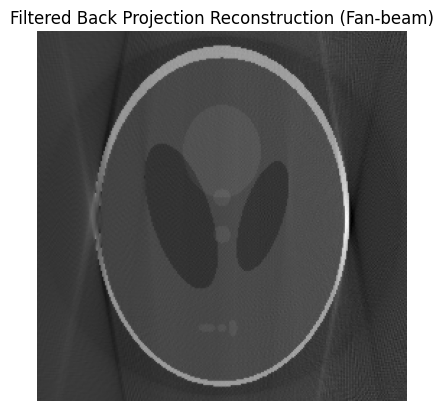

In [ ]:
# Volume geometry
vol_geom = astra.create_vol_geom(256, 256)

# Fan-beam projection geometry
num_angles = 180
num_detectors = 512           # usually larger than volume size
detector_spacing = 1.0

angles = np.linspace(0, np.pi, num_angles, endpoint=False)

# Fan beam geometry parameters
source_origin_dist = 500.0    # distance from source to origin
origin_det_dist = 500.0       # distance from origin to detector

proj_geom = astra.create_proj_geom('fanflat', detector_spacing, num_detectors,
                                   angles, source_origin_dist, origin_det_dist)

# Create projector (GPU)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

# Generate phantom image (same as before)
V_exact_id, V_exact = astra.data2d.shepp_logan(vol_geom)

# Create forward projection (sinogram)
sinogram_id_fanflat, sinogram_fanflat = astra.create_sino(V_exact, proj_id)

# Initialize reconstruction volume with ones
recon_id = astra.data2d.create('-vol', vol_geom, 1.0)

# Configure EM_CUDA algorithm
cfg = astra.astra_dict('FBP_CUDA')
cfg['ProjectorId'] = proj_id
cfg['ProjectionDataId'] = sinogram_id_fanflat
cfg['ReconstructionDataId'] = recon_id

# Create and run the algorithm
fbp_id = astra.algorithm.create(cfg)
astra.algorithm.run(fbp_id)

# Get reconstructed image
V_fbp_fanflat = astra.data2d.get(recon_id)

# Plot
plt.gray()
plt.imshow(V_fbp_fanflat)
plt.title('Filtered Back Projection Reconstruction (Fan-beam)')
plt.axis('off')
plt.show()

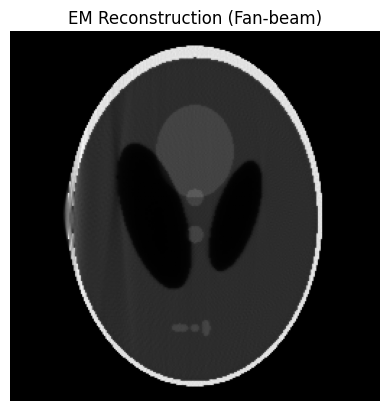

In [ ]:
# Volume geometry
vol_geom = astra.create_vol_geom(256, 256)

# Fan-beam projection geometry
num_angles = 180
num_detectors = 512           # usually larger than volume size
detector_spacing = 1.0

angles = np.linspace(0, np.pi, num_angles, endpoint=False)

# Fan beam geometry parameters
source_origin_dist = 500.0    # distance from source to origin
origin_det_dist = 500.0       # distance from origin to detector

proj_geom = astra.create_proj_geom('fanflat', detector_spacing, num_detectors,
                                   angles, source_origin_dist, origin_det_dist)

# Create projector (GPU)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

# Generate phantom image (same as before)
V_exact_id, V_exact = astra.data2d.shepp_logan(vol_geom)

# Create forward projection (sinogram)
sinogram_id_fanflat, sinogram_fanflat = astra.create_sino(V_exact, proj_id)

# Initialize reconstruction volume with ones
recon_id = astra.data2d.create('-vol', vol_geom, 1.0)

# Configure SIRT_CUDA algorithm
cfg = astra.astra_dict('EM_CUDA')
cfg['ProjectorId'] = proj_id
cfg['ProjectionDataId'] = sinogram_id_fanflat
cfg['ReconstructionDataId'] = recon_id

# Create and run the algorithm
em_id = astra.algorithm.create(cfg)
astra.algorithm.run(em_id, 200)

# Get reconstructed image
V_em_fanflat = astra.data2d.get(recon_id)

# Plot
plt.gray()
plt.imshow(V_em_fanflat)
plt.title('EM Reconstruction (Fan-beam)')
plt.axis('off')
plt.show()

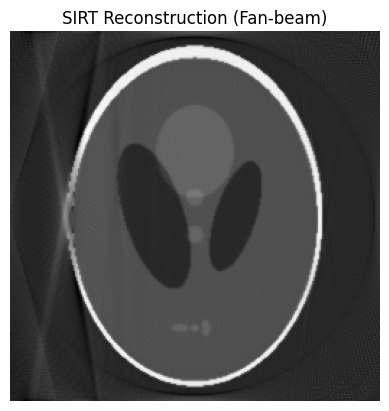

In [ ]:
# Volume geometry
vol_geom = astra.create_vol_geom(256, 256)

# Fan-beam projection geometry
num_angles = 180
num_detectors = 512           # usually larger than volume size
detector_spacing = 1.0

angles = np.linspace(0, np.pi, num_angles, endpoint=False)

# Fan beam geometry parameters
source_origin_dist = 500.0    # distance from source to origin
origin_det_dist = 500.0       # distance from origin to detector

proj_geom = astra.create_proj_geom('fanflat', detector_spacing, num_detectors,
                                   angles, source_origin_dist, origin_det_dist)

# Create projector (GPU)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

# Generate phantom image (same as before)
V_exact_id, V_exact = astra.data2d.shepp_logan(vol_geom)

# Create forward projection (sinogram)
sinogram_id_fanflat, sinogram_fanflat = astra.create_sino(V_exact, proj_id)

# Initialize reconstruction volume with ones
recon_id = astra.data2d.create('-vol', vol_geom, 1.0)

# Configure SIRT_CUDA algorithm
cfg = astra.astra_dict('SIRT_CUDA')
cfg['ProjectorId'] = proj_id
cfg['ProjectionDataId'] = sinogram_id_fanflat
cfg['ReconstructionDataId'] = recon_id

# Create and run the algorithm
sirt_id = astra.algorithm.create(cfg)
astra.algorithm.run(sirt_id, 200)

# Get reconstructed image
V_sirt_fanflat = astra.data2d.get(recon_id)

# Plot
plt.gray()
plt.imshow(V_sirt_fanflat)
plt.title('SIRT Reconstruction (Fan-beam)')
plt.axis('off')
plt.show()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Assume:
# V_fbp_para = astra.data2d.get(recon_id)
# V_exact_id, V_exact = astra.data2d.shepp_logan(vol_geom)

# --- 1. MSE ---
mse_fbp_para = np.mean((V_fbp_para - V_exact)**2)

# --- 2. RMSE ---
rmse_fbp_para = np.sqrt(mse_fbp_para)

# --- 3. PSNR ---
# Assume max pixel value = 1.0 for normalized images
psnr = peak_signal_noise_ratio(V_exact, V_fbp_para, data_range=1.0)

# --- 4. SSIM ---
ssim = structural_similarity(V_exact, V_fbp_para, data_range=1.0)

# --- 5. NRMSE ---
nrmse = rmse_fbp_para / np.linalg.norm(V_exact)

print("Error metrics for FBP in parallel beam geometry")
print(f"MSE: {mse_fbp_para:.6f}")
print(f"RMSE: {rmse_fbp_para:.6f}")
print(f"NRMSE: {nrmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

Error metrics for FBP in parallel beam geometry
MSE: 0.002055
RMSE: 0.045337
NRMSE: 0.000717
PSNR: 26.87 dB
SSIM: 0.6407


In [ ]:
mse = np.mean((V_fbp_fanflat - V_exact)**2)

# --- 2. RMSE ---
rmse = np.sqrt(mse)

# --- 3. PSNR ---
# Assume max pixel value = 1.0 for normalized images
psnr = peak_signal_noise_ratio(V_exact, V_fbp_fanflat, data_range=1.0)

# --- 4. SSIM ---
ssim = structural_similarity(V_exact, V_fbp_fanflat, data_range=1.0)

# --- 5. NRMSE ---
nrmse = rmse / np.linalg.norm(V_exact)

print("Error metrics for FBP in fan beam geometry")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"NRMSE: {nrmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

Error metrics for FBP in fan beam geometry
MSE: 0.007026
RMSE: 0.083823
NRMSE: 0.001325
PSNR: 21.53 dB
SSIM: 0.4046


In [ ]:
mse = np.mean((V_sirt_para - V_exact)**2)

# --- 2. RMSE ---
rmse = np.sqrt(mse)

# --- 3. PSNR ---
# Assume max pixel value = 1.0 for normalized images
psnr = peak_signal_noise_ratio(V_exact, V_sirt_para, data_range=1.0)

# --- 4. SSIM ---
ssim = structural_similarity(V_exact, V_sirt_para, data_range=1.0)

# --- 5. NRMSE ---
nrmse = rmse / np.linalg.norm(V_exact)

print("Error metrics for SIRT in parallel beam geometry")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"NRMSE: {nrmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

Error metrics for SIRT in parallel beam geometry
MSE: 0.002014
RMSE: 0.044883
NRMSE: 0.000709
PSNR: 26.96 dB
SSIM: 0.8671


In [ ]:
mse = np.mean((V_sirt_fanflat - V_exact)**2)

# --- 2. RMSE ---
rmse = np.sqrt(mse)

# --- 3. PSNR ---
# Assume max pixel value = 1.0 for normalized images
psnr = peak_signal_noise_ratio(V_exact, V_sirt_fanflat, data_range=1.0)

# --- 4. SSIM ---
ssim = structural_similarity(V_exact, V_sirt_fanflat, data_range=1.0)

# --- 5. NRMSE ---
nrmse = rmse / np.linalg.norm(V_exact)

print("Error metrics for SIRT in fan beam geometry")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"NRMSE: {nrmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

Error metrics for SIRT in fan beam geometry
MSE: 0.003414
RMSE: 0.058433
NRMSE: 0.000924
PSNR: 24.67 dB
SSIM: 0.6949


In [ ]:
mse = np.mean((V_em_para - V_exact)**2)

# --- 2. RMSE ---
rmse = np.sqrt(mse)

# --- 3. PSNR ---
# Assume max pixel value = 1.0 for normalized images
psnr = peak_signal_noise_ratio(V_exact, V_em_para, data_range=1.0)

# --- 4. SSIM ---
ssim = structural_similarity(V_exact, V_em_para, data_range=1.0)

# --- 5. NRMSE ---
nrmse = rmse / np.linalg.norm(V_exact)

print("Error metrics for EM in parallel beam geometry")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"NRMSE: {nrmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

Error metrics for FBP in fan beam geometry
MSE: 0.000602
RMSE: 0.024528
NRMSE: 0.000388
PSNR: 32.21 dB
SSIM: 0.9418


In [ ]:
mse = np.mean((V_em_fanflat - V_exact)**2)

# --- 2. RMSE ---
rmse = np.sqrt(mse)

# --- 3. PSNR ---
# Assume max pixel value = 1.0 for normalized images
psnr = peak_signal_noise_ratio(V_exact, V_em_fanflat, data_range=1.0)

# --- 4. SSIM ---
ssim = structural_similarity(V_exact, V_em_fanflat, data_range=1.0)

# --- 5. NRMSE ---
nrmse = rmse / np.linalg.norm(V_exact)

print("Error metrics for EM in fan beam geometry")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"NRMSE: {nrmse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

Error metrics for EM in fan beam geometry
MSE: 0.000905
RMSE: 0.030078
NRMSE: 0.000475
PSNR: 30.43 dB
SSIM: 0.9384


In [ ]:
# Technique names
techniques = ['BP_cone', 'BP_parallel3d', 'SIRT_cone', 'SIRT_parallel3d']

# MSE values (make sure these variables are defined earlier in your code)
MSEs = [mse_bp_cone, mse_bp_para, mse_sirt_cone, mse_sirt_para]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(techniques, MSEs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.001, f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

# Formatting
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('MSE Comparison of Reconstruction Techniques', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()